#Imports

In [ ]:
pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import math
from loguru import logger
from pathlib import Path
import os
import glob
from functools import reduce
from google.colab import drive
from google.colab.data_table import DataTable

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
DataTable.max_columns = 30
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
month = 'Mai'
year = '2020'

# Get intervals

## Functions

In [ ]:

# log
def log(f, message, err):
    logger.warning(message.format(err=repr(err), f=f))
    raise type(err)(message.format(err=repr(err), f=f))


# get_path
def get_path():
    try:
        path = Path("gdrive", "MyDrive", "dados SOAN")
        return path
    except FileNotFoundError as err:
        raise err
    except Exception as err:
        raise log("get_path", "error in {f}: {err}", err)


# get_soan_path
def get_soan_path():
    path = get_path()
    try:
        path_soan = Path(path, "Cenarios primeiro semestre 2020")
        return path_soan
    except FileNotFoundError as err:
        raise err
    except Exception as err:
        log("get_soan_path", "error in {f}: {err}", err)


# get_path_ship_cargoes
def get_path_ship_cargoes():
    path = get_path()
    try:
        path_shipment_cargoes = Path(
            path, "Realizado - Operations Desk", "Shipment Cargoes.xlsx"
        )
        return path_shipment_cargoes
    except FileNotFoundError as err:
        raise err
    except Exception as err:
        log("get_path_ship_cargoes", "error in {f}: {err}", err)


# get_real_supply
def get_ship_cargoes(param):
    try:

        path = get_path_ship_cargoes()
        df = pd.read_excel(path)

        # filtering
        df = df.loc[(df["Origin Port"] == "Port A"), :]
        df["year"] = df["Origin ETA"].dt.year
        df["month"] = df["Origin ETA"].dt.month
        if param == "demand":
            df = df.loc[(df["Incoterm"] == "FOB"), :]

        # preparing data
        df["Product"] = df["Product"].astype("string")
        df_aux = df[["month", "Product", "Quantity (t)"]]
        if param == "demand":
            df_aux.rename(
                columns={"Quantity (t)": "Quantity Realized"}, inplace=True)
        else:
            df_aux.rename(
                columns={"Quantity (t)": "Amount Realized"}, inplace=True)

        df_aux = df_aux.groupby(["month", "Product"], as_index=False).sum()
        return df_aux
    except Exception as err:
        log("get_ship_cargoes", "error in {f}: {err}", err)


# get_path_berth()
def get_path_berth():
    path = get_path()
    try:
        path_berth = Path(
            path, "Realizado- Berth Outlfow Capacity"
        )
        return path_berth
    except FileNotFoundError as err:
        raise err
    except Exception as err:
        log("get_path_berth", "error in {f}: {err}", err)

def get_berth(port):
    try:

        path = get_path_berth()
        if port == 'Port A':
          path = str(path)+'/port-a/*.xlsx'

        if port == 'Porto B':
          path = str(path)+'/port-b/.xlsx'

        file_list = glob.glob(path)
        excel_list = []
        for file in file_list:
              df = pd.read_excel(file)
              excel_list.append(df)
        return excel_list[0]
    except Exception as err:
        log("get_data", "error in {f}: {err}", err)

# get_data
def get_data(year, month, file_title, path):

    try:
        path = "{path}/*{month}*{year}/*/*{file_title}.xlsx".format(
            path=str(path), month=str(month), year=str(year), file_title=str(file_title)
        )
        file_list = glob.glob(path)
        excel_list = []
        for file in file_list:
            df = pd.read_excel(file)
            excel_list.append(df)

        return excel_list
    except Exception as err:
        log("get_data", "error in {f}: {err}", err)


# merge_plan_real
def merge_plan_real(df_plan, df_real, how):
    try:
        df_merge = df_real.merge(df_plan, how=how)
        return df_merge
    except Exception as err:
        log("merge_plan_real", "error in {f}: {err}", err)


# get_fine_tune_eta
def get_fine_tune_eta(df_plan, df_real):
    try:
        return ""
    except Exception as err:
        log("get_fine_tune_eta", "error in {f}: {err}", err)


# get_fine_tune_berth
def get_fine_tune_berth(df_plan, df_real):
    try:
        diffs = []

        for idx, df in enumerate(df_plan):
            df_merge = merge_plan_real(df, df_real, "outer")
            df_merge["Monthly Outflow Capacity Realized"] = df_merge[
                "Monthly Outflow Capacity Realized"
            ].fillna(0)
            df_merge["Monthly Outflow Capacity " + str(idx)] = df_merge[
                "Monthly Outflow Capacity"
            ].fillna(0)
            df_merge = df_merge.drop(columns=["Monthly Outflow Capacity"])
            diffs.append(df_merge)
        return diffs
    except Exception as err:
        log("get_fine_tune_berth", "error in {f}: {err}", err)


# get_fine_tune_demand
def get_fine_tune_demand(df_plan, df_real):
    try:
        diffs = []

        for idx, df in enumerate(df_plan):
            df_merge = merge_plan_real(df, df_real, "outer")

            df_merge["Quantity Realized"] = df_merge["Quantity Realized"].fillna(
                0)
            df_merge["Quantity"] = df_merge["Quantity"].fillna(0)
            df_merge["div_quantity_" +
                     str(idx)] = (df_merge["Quantity Realized"] / df_merge["Quantity"])
            diffs.append(df_merge)

        return diffs
    except Exception as err:
        log("get_fine_tune_demand", "error in {f}: {err}", err)


# get_fine_tune_supply
def get_fine_tune_supply(df_plan, df_real):
    try:
        diffs = []

        for idx, df in enumerate(df_plan):
            df_merge = merge_plan_real(df, df_real, "outer")
            df_merge["Amount Realized"] = df_merge["Amount Realized"].fillna(0)
            df_merge["Amount"] = df_merge["Amount"].fillna(0)
            df_merge["div_amount_" + str(idx)] = (
                df_merge["Amount Realized"] / df_merge["Amount"]
            )
            diffs.append(df_merge)
        return diffs
    except Exception as err:
        log("get_fine_tune_supply", "error in {f}: {err}", err)


# get_fine_tune
def get_fine_tune(df_plan, df_real, variable):

    if (variable == 'supply'):
      return get_fine_tune_supply(df_plan, df_real)
    elif (variable == 'eta'):
      return get_fine_tune_eta(df_plan, df_real)
    elif (variable == 'berth'):
      return get_fine_tune_berth(df_plan, df_real)
    elif (variable == 'demand'):
      return get_fine_tune_demand(df_plan, df_real)
    else:
      Exception("Necessary inform a valid variable string")

# lp_seq
def lp_seq():
    return pd.DataFrame(
        {
            "s": [1, 2, 3, 4, 5, 6, 7],
            "t=1": [0.500, 0.250, 0.750, 0.125, 0.625, 0.375, 0.875],
            "t=2": [0.500, 0.750, 0.250, 0.625, 0.125, 0.375, 0.875],
            "t=3": [0.500, 0.250, 0.750, 0.875, 0.375, 0.625, 0.125],
            "t=4": [0.500, 0.750, 0.250, 0.875, 0.375, 0.125, 0.625],
        })

## Supply

### Functions

In [ ]:
# get_plan_supply
def get_plan_supply(excel_list):
    try:
        dfs = []

        for df in excel_list:
            # filtering
            df = df.loc[(df["Port*"] == "PMA"), :]
            df["year"] = df["Start Date*"].dt.year
            df["month"] = df["Start Date*"].dt.month
            # preparing data
            df_aux = df[["month", "Product*", "Amount*"]]
            df_aux.rename(
                columns={"month": "month",
                         "Product*": "Product", "Amount*": "Amount"},
                inplace=True,
            )
            df_aux["Product"] = df_aux["Product"].astype("string")
            df_aux = df_aux.groupby(["month", "Product"], as_index=False).sum()
            dfs.append(df_aux)
        return dfs
    except Exception as err:
        log("get_plan_supply", "error in {f}: {err}", err)

def get_final_supply(diffs):
    try:
        df = reduce(
            lambda df1, df2: pd.merge(df1, df2, on=["month", "Product"]), diffs
        )

        # filtering
        df = df.filter(
            regex="month|Product|div_amount*", axis=1
        )
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df = df.fillna(0)



        # getting max_min values
        df_div_value = df.filter(regex="div_amount*", axis=1)
        df["min_value"] = df_div_value.min(axis=1)
        df["max_value"] = df_div_value.max(axis=1)
        df = df[df["max_value"] > 0]

        return df
    except Exception as err:
        log("get_final_supply", "error in {f}: {err}", err)


### Core

In [ ]:
path = get_soan_path()

sheets = get_data(year, month, 'Supply', path)

plan_supply = get_plan_supply(sheets)

real_supply = get_ship_cargoes('supply')

diffs = get_fine_tune(plan_supply, real_supply, 'supply')

final_supply = get_final_supply(diffs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [ ]:
final_supply

,month,Product,div_amount_0,div_amount_1,div_amount_2,div_amount_3,min_value,max_value
1,1,AF73,1.26,1.26,1.26,1.26,1.26,1.26
3,1,IOCJ,4.66,4.66,4.66,4.66,4.66,4.66
5,1,LOCJ,1.27,1.27,1.27,1.27,1.27,1.27
9,1,SFKT,2.59,2.59,2.59,2.59,2.59,2.59
11,2,AF70,7.04,7.04,7.04,7.04,7.04,7.04
...,...,...,...,...,...,...,...,...
145,12,LOCJ,1.28,0.66,1.27,1.27,0.66,1.28
146,12,MF14,0.00,0.13,0.00,0.00,0.00,0.13
149,12,SFKP,3.96,3.96,3.96,3.96,3.96,3.96
150,12,SFKT,4.01,2.00,2.00,2.00,2.00,4.01


## Berth Outflow Capacity

### Functions

In [ ]:
def get_plan_berth(excel_list):
    try:
        dfs = []

        for df in excel_list:
            # filtering
            df["year"] = df["Date*"].dt.year
            df["month"] = df["Date*"].dt.month

            # preparing data

            df_aux = df[["month", "Berth*", "Monthly Outflow Capacity*"]]
            df_aux.rename(
                columns={
                    "month": "month",
                    "Berth*": "Berth",
                    "Monthly Outflow Capacity*": "Monthly Outflow Capacity",
                },
                inplace=True,
            )
            df_aux["Berth"] = df_aux["Berth"].astype("string")
            df_aux = (
                df_aux.groupby(["month", "Berth"], as_index=False)
                .sum()
                .sort_values("month")
            )
            dfs.append(df_aux)
        return dfs
    except Exception as err:
        log("get_plan_berth", "error in {f}: {err}", err)

# prepare_df_pma()

def prepare_df_pma(df):
    try:
        df.columns = ["year", "month", "1", "3N", "3S", "4N", "4S", "Total"]
        df = df.iloc[1:, :]
        df["month"] = df["month"].astype("string")
        df = df.loc[df.month.str.contains("\d"), :]
        df = df.fillna(0)
        df.reset_index(drop=True)
        df = pd.melt(
            df, id_vars=["year", "month", "Total"], value_name="Berth"
        ).sort_values("month")
        df.rename(
            columns={"variable": "Berth",
                    "Berth": "Monthly Outflow Capacity Realized"},
            inplace=True,
        )
        df = df.groupby(["month", "Berth"],
                        as_index=False).sum().sort_values("month")
        df["month"] = df["month"].astype(str).astype(int)
        df["Port*"] = "Ponta da Madeira"
        return df
    except Exception as err:
        log("prepare_df_pma", "error in {f}: {err}", err)

# prepare_df_tu(df_raw_tu)

def prepare_df_tu(df):
    try:
        df.columns = ["year", "month", "02", "1N", "1S", "Total"]
        df = df.iloc[1:, :]
        df["month"] = df["month"].astype("string")
        df = df.loc[df.month.str.contains("\d"), :]
        df = df.fillna(0)
        df.reset_index(drop=True)

        df = pd.melt(
            df, id_vars=["year", "month", "Total"], value_name="Berth"
        ).sort_values("month")

        df.rename(
            columns={"variable": "Berth",
                    "Berth": "Monthly Outflow Capacity Realized"},
            inplace=True,
        )
        df = df.groupby(["month", "Berth"],
                        as_index=False).sum().sort_values("month")
        df["month"] = df["month"].astype(str).astype(int)
        df["Port*"] = "Tubarao"

        return df
    except Exception as err:
        log("prepare_df_tu", "error in {f}: {err}", err)



# get_real_berth():
def get_real_berth():
    try:

        df_raw_pma = get_berth('Porto TMPM')
        df_raw_tub = get_berth('Porto TU')

        df_pma = prepare_df_pma(df_raw_pma)
        df_tub = prepare_df_tu(df_raw_tub)

        df_real = df_pma.merge(df_tub, on = ['Port*','year', 'month','Berth','Monthly Outflow Capacity Realized', 'Total'], how = 'outer').sort_values('month')

        return df_real
    except Exception as err:
        log("get_real_berth", "error in {f}: {err}", err)

# change_for_max_values


def change_for_max_values(a, b):
    return max([a,b])


# change_for_min_values
def change_for_min_values(a,b):
    return min([a,b])


# get_final_berth
def get_final_berth(diffs):
    try:
        df = reduce(
            lambda df1, df2: pd.merge(
                df1,
                df2,
                on=[
                    'Port*',
                    "month",
                    "Berth",
                    "Monthly Outflow Capacity Realized",
                    "year",
                    "Total",
                ],
            ),
            diffs,
        )
        df = df.filter(
            regex="Port*|month|Berth|Monthly Outflow Capacity Realized|Monthly Outflow Capacity 0",
            axis=1,
        )
        df.rename(
            columns={
                "Monthly Outflow Capacity Realized": "max_value",
                "Monthly Outflow Capacity 0": "min_value",
            },
            inplace=True,
        )
        # df_final_berth.replace([np.inf, -np.inf], np.nan, inplace=True)
        df = df.fillna(0)

        df["new_max"] =   df.apply(lambda x: change_for_max_values(x['max_value'], x['min_value']), axis=1)
        df["new_min"] =   df.apply(lambda x: change_for_min_values(x['max_value'], x['min_value']), axis=1)

        df.drop(['max_value', 'min_value'], inplace=True, axis=1)
        df.rename(columns={"new_max": "max_value","new_min": "min_value"},inplace=True)
        return df
    except Exception as err:
        log("get_final_berth", "error in {f}: {err}", err)


### Core

In [ ]:
path = get_soan_path()

sheets = get_data(year,month,'Berth Outflow Capacity',path)

plan_berth = get_plan_berth(sheets)

real_berth = get_real_berth()

diffs = get_fine_tune(plan_berth, real_berth, 'berth')

final_berth = get_final_berth(diffs)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

## ETA

### ETA - year-month

In [ ]:

path = get_soan_path()

sheets = get_data(year,month,'Vessel Calculated ETA',path)

ports = get_data(year,month,'Ports',path)


In [ ]:

df_etas = []
for dataframe in sheets:
    df_eta = dataframe
    port = ports[0]
    df_eta["month"] = df_eta["ETA*"].dt.month
    df_port = port[["International Code*", "Name*"]]
    df_port.rename(
        columns={
            "International Code*": "Port*",
            "Name*": "Origin Port",
        },
        inplace=True,
    )

    df_eta = df_eta.merge(df_port, how="inner")
    df_eta.drop(["Port*"], inplace=True, axis=1)
    df_eta["vessel_IMO-month-Port-vessel_class"] = (
        df_eta["Vessel IMO*"].astype(str)
        + "-"
        + df_eta["month"].astype(str)
        + "-"
        + df_eta["Origin Port"].astype(str)
        + "-"
        + df_eta["Vessel Class"].astype(str)
    )
    df_eta = df_eta[
        ["Vessel IMO*", "ETA*", "month", "Origin Port", "vessel_IMO-month-Port-vessel_class"]
    ].sort_values("vessel_IMO-month-Port-vessel_class")

    df_etas.append(df_eta)
df_etas[0]



,Vessel IMO*,ETA*,month,Origin Port,vessel_IMO-month-Port-vessel_class
401,8888027,2020-08-31 04:22:00,8,Sepetiba,8888027-8-Sepetiba-VLOC
280,8888027,2020-09-02 17:35:00,9,Guaiba,8888027-9-Guaiba-VLOC
174,8888027,2020-09-06 00:00:00,9,Ponta da Madeira,8888027-9-Ponta da Madeira-VLOC
242,8888027,2020-09-01 03:13:00,9,Tubarao,8888027-9-Tubarao-VLOC
291,8888030,2020-08-14 17:35:00,8,Guaiba,8888030-8-Guaiba-VLOC
...,...,...,...,...,...
57,9860544,2020-06-22 12:00:00,6,Qingdao,9860544-6-Qingdao-Panamax
286,9999928,2020-07-21 08:10:00,7,Guaiba,9999928-7-Guaiba-Newcastlemax
128,9999928,2020-07-25 00:00:00,7,Ponta da Madeira,9999928-7-Ponta da Madeira-Newcastlemax
396,9999928,2020-07-18 11:36:00,7,Sepetiba,9999928-7-Sepetiba-Newcastlemax


In [ ]:
path = get_path_ship_cargoes()
df_ship_cargoes = pd.read_excel(path)

df_ship_cargoes['month'] = df_ship_cargoes['Origin ETA'].dt.month
df_ship_cargoes['IMO'] = df_ship_cargoes["IMO"].fillna(0.0).astype(int)
df_ship_cargoes['Vessel IMO*'] = df_ship_cargoes["IMO"]
df_ship_cargoes.drop(['IMO'], inplace=True, axis=1)

df_ship_cargoes['vessel_IMO-month-Port-vessel_class'] = (
    df_ship_cargoes['Vessel IMO*'].astype(str)
    + '-'
    + df_ship_cargoes['month'].astype(str)
    + '-'
    + df_ship_cargoes['Origin Port'].astype(str)
    + '-'
    + df_ship_cargoes['Vessel Class'].astype(str)
)
df_ship_cargoes = df_ship_cargoes[['vessel_IMO-month-Port-vessel_class', 'Origin ETA', 'Vessel IMO*','month']].sort_values('vessel_IMO-month-Port-vessel_class')
df_ship_cargoes


,vessel_IMO-month-Port-vessel_class,Origin ETA,Vessel IMO*,month
10993,0-1-Dongjiakou-Handymax,2021-01-29 08:00:00,0,1
10762,0-1-Gregorio Curvo-Barge,2019-01-04 00:00:00,0,1
10766,0-1-Gregorio Curvo-Barge,2019-01-31 00:00:00,0,1
10765,0-1-Gregorio Curvo-Barge,2019-01-31 00:00:00,0,1
10764,0-1-Gregorio Curvo-Barge,2019-01-04 00:00:00,0,1
...,...,...,...,...
10747,9926398-2-Sepetiba-Newcastlemax,2022-02-28 10:42:00,9926398,2
10748,9939072-2-Ponta da Madeira-Babycape,2022-02-22 10:00:00,9939072,2
10749,9939072-2-Ponta da Madeira-Babycape,2022-02-22 10:00:00,9939072,2
10750,9939072-3-Ponta da Madeira-Babycape,2022-03-14 16:30:00,9939072,3


In [ ]:
df_difs_eta = []

for idx, df_eta in enumerate(df_etas):
  max_date = df_eta['ETA*'].max()
  df_ship_cargoes_aux = df_ship_cargoes.loc[(df_ship_cargoes["Origin ETA"]<= max_date)]

  df_dif = df_eta.merge(df_ship_cargoes_aux, how = 'inner')
  df_dif['diff_days_' + str(idx)] = df_dif['Origin ETA'] - df_dif['ETA*']
  df_dif['diff_days_' + str(idx)] = (df_dif['diff_days_'+ str(idx)]/(np.timedelta64(1,'D')))
  df_difs_eta.append(df_dif)
df_difs_eta[1]

,Vessel IMO*,ETA*,month,Origin Port,vessel_IMO-month-Port-vessel_class,Origin ETA,diff_days_1
0,9325013,2020-05-28 08:59:36,5,Sepetiba,9325013-5-Sepetiba-Capesize,2020-05-31 13:03:00,3.17
1,9325013,2020-05-28 08:59:36,5,Sepetiba,9325013-5-Sepetiba-Capesize,2020-05-31 13:03:00,3.17
2,9334870,2020-05-28 23:00:00,5,Ponta da Madeira,9334870-5-Ponta da Madeira-VLOC,2018-05-02 10:30:00,-757.52
3,9334870,2020-05-28 23:00:00,5,Ponta da Madeira,9334870-5-Ponta da Madeira-VLOC,2020-05-27 22:15:00,-1.03
4,9375757,2020-05-25 14:00:00,5,Guaiba,9375757-5-Guaiba-VLOC,2020-05-26 15:18:00,1.05
...,...,...,...,...,...,...,...
95,9850111,2020-06-01 18:11:00,6,Ponta da Madeira,9850111-6-Ponta da Madeira-Guaibamax,2020-06-02 18:30:00,1.01
96,9850111,2020-06-01 18:11:00,6,Ponta da Madeira,9850111-6-Ponta da Madeira-Guaibamax,2020-06-02 18:30:00,1.01
97,9850111,2020-06-01 18:11:00,6,Ponta da Madeira,9850111-6-Ponta da Madeira-Guaibamax,2020-06-02 18:30:00,1.01
98,9853723,2020-05-27 10:00:00,5,Ponta da Madeira,9853723-5-Ponta da Madeira-Capesize,2020-05-26 22:00:00,-0.50


In [ ]:
df_final_eta = reduce(lambda df1,df2: pd.merge(df1,df2,on=['vessel_IMO-month-Port-vessel_class', 'Vessel IMO*', 'month', 'Origin Port' ], how = 'outer'), df_difs_eta)
df_final_eta

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ETA*_x', 'Origin ETA_x'} in the result is deprecated and will raise a MergeError in a future version.
  """Entry point for launching an IPython kernel.


,Vessel IMO*,ETA*_x,month,Origin Port,vessel_IMO-month-Port-vessel_class,Origin ETA_x,diff_days_0,ETA*_y,Origin ETA_y,diff_days_1,ETA*_x,Origin ETA_x,diff_days_2,ETA*_y,Origin ETA_y,diff_days_3
0,9273375,2020-06-06 12:00:00,6,Ponta da Madeira,9273375-6-Ponta da Madeira-Capesize,2020-06-06 06:25:00,-0.23,NaT,NaT,NaN,2020-06-07 13:06:00,2020-06-06 06:25:00,-1.28,NaT,NaT,NaN
1,9273375,2020-06-06 12:00:00,6,Ponta da Madeira,9273375-6-Ponta da Madeira-Capesize,2020-06-06 06:25:00,-0.23,NaT,NaT,NaN,2020-06-07 13:06:00,2020-06-06 06:25:00,-1.28,NaT,NaT,NaN
2,9273375,2020-06-06 12:00:00,6,Ponta da Madeira,9273375-6-Ponta da Madeira-Capesize,2020-06-06 06:25:00,-0.23,NaT,NaT,NaN,2020-06-07 13:06:00,2020-06-06 06:25:00,-1.28,NaT,NaT,NaN
3,9273375,2020-06-06 12:00:00,6,Ponta da Madeira,9273375-6-Ponta da Madeira-Capesize,2020-06-06 06:25:00,-0.23,NaT,NaT,NaN,2020-06-07 13:06:00,2020-06-06 06:25:00,-1.28,NaT,NaT,NaN
4,9295012,2020-05-23 22:46:19,5,Teluk Rubiah Maritime Terminal,9295012-5-Teluk Rubiah Maritime Terminal-Capesize,2020-05-20 00:30:00,-3.93,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,9822255,NaT,5,Ponta da Madeira,9822255-5-Ponta da Madeira-VLOC,NaT,NaN,NaT,NaT,NaN,NaT,NaT,NaN,2020-05-06 20:00:00,2019-05-31 00:42:00,-341.80
1149,9822255,NaT,5,Ponta da Madeira,9822255-5-Ponta da Madeira-VLOC,NaT,NaN,NaT,NaT,NaN,NaT,NaT,NaN,2020-05-06 20:00:00,2020-05-06 12:00:00,-0.33
1150,9822255,NaT,5,Ponta da Madeira,9822255-5-Ponta da Madeira-VLOC,NaT,NaN,NaT,NaT,NaN,NaT,NaT,NaN,2020-05-06 20:00:00,2019-05-31 00:42:00,-341.80
1151,9845128,NaT,5,Ponta da Madeira,9845128-5-Ponta da Madeira-Guaibamax,NaT,NaN,NaT,NaT,NaN,NaT,NaT,NaN,2020-05-09 20:00:00,2020-05-09 16:50:00,-0.13


In [ ]:
df_final_eta.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final_eta = df_final_eta.fillna(0)

df_div_value_eta = df_final_eta.filter(regex='diff_days_*', axis=1)
df_final_eta['min_value'] = df_div_value_eta.min(axis=1)
df_final_eta['max_value'] = df_div_value_eta.max(axis=1)

df_final_eta_filtered = df_final_eta.filter(regex='Vessel IMO*|vessel_IMO-month-Port-vessel_class|diff_days_*|min_value|max_value', axis=1)

#df_final_eta_filtered_aux = df_final_eta_filtered.loc[(df_final_eta_filtered['vesselIMO-month-Port'] == '9532549-4-Ponta da Madeira')]['min_value'].min()
#  df_sup_list_f1 = df_sup_list.loc[(df_sup_list["Start Date*"]>= '2021-12-01') &(df_sup_list["Start Date*"]<= '2022-06-30') ]
#df_final_eta_filtered_gb = df_final_eta_filtered.groupby(['vessel_IMO-month-Port-vessel_class', "min_value","max_value"], as_index=False)

df_final_eta_filtered = df_final_eta_filtered.loc[(df_final_eta_filtered["min_value"] > -50), :]


final_eta = df_final_eta_filtered

## Demand

### Functions

In [ ]:

# get_plan_demand
def get_plan_demand(excel_list):
    try:
        dfs = []
        for df in excel_list:
            # filtering
            df = df.loc[(df["Port Origin*"] == "PMA"), :]
            df = df.loc[(df["Incoterm*"] == "FOB"), :]
            df["year"] = df["Start Date*"].dt.year
            df["month"] = df["Start Date*"].dt.month
            # preparing data
            df_aux = df[["month", "Product*", "Quantity*"]]
            df_aux.rename(
                columns={
                    "month": "month",
                    "Product*": "Product",
                    "Quantity*": "Quantity",
                },
                inplace=True,
            )
            df_aux["Product"] = df_aux["Product"].astype("string")
            df_aux = df_aux.groupby(["month", "Product"], as_index=False).sum()
            dfs.append(df_aux)
        return dfs
    except Exception as err:
        log("get_plan_demand", "error in {f}: {err}", err)


# get_final_demand
def get_final_demand(diffs):
    try:

        df = reduce(lambda df1, df2: pd.merge(
            df1, df2, on=["month", "Product"]), diffs)
        df = df.filter(regex="month|Product|div_quantity*", axis=1)
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df = df.fillna(0)

        df_div = df.filter(regex="div_quantity*", axis=1)
        df["min_value"] = df_div.min(axis=1)
        df["max_value"] = df_div.max(axis=1)
        df = df[df["max_value"] > 0]

        return df
    except Exception as err:
        log("get_final_demand", "error in {f}: {err}", err)


### Core

In [ ]:
path = get_soan_path()

sheets = get_data(year,month,'Demand',path)

plan_demand = get_plan_demand(sheets)

real_demand = get_ship_cargoes('demand')

diffs = get_fine_tune(plan_demand, real_demand, 'demand')

final_demand = get_final_demand(diffs)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Quantity Realized_x', 'Quantity_x'} in the result is deprecated and will raise a MergeError in a future version.


In [ ]:
plan_demand[0]

,month,Product,Quantity
0,1,IOCJ,"707,359.00"
1,2,AF70,"84,326.00"
2,2,IOCJ,"1,505,432.00"
3,3,AF70,"253,000.00"
4,3,IOCJ,"3,023,856.00"
5,4,IOCJ,"1,739,257.00"
6,5,IOCJ,"2,278,700.00"
7,6,IOCJ,"2,862,083.00"
8,7,AF70,"77,150.00"
9,7,IOCJ,"3,970,319.67"


In [ ]:
plan_supply[0]

,month,Product,Amount
0,1,AF70,0.00
1,1,AF73,"206,314.00"
2,1,FPR1,0.00
3,1,IOCJ,"13,664,582.00"
4,1,IOKN,0.00
...,...,...,...
151,12,PFCJ,0.00
152,12,SFKP,"390,000.00"
153,12,SFKT,"80,000.00"
154,12,SFM1,0.00


# Create LPτ-sequences

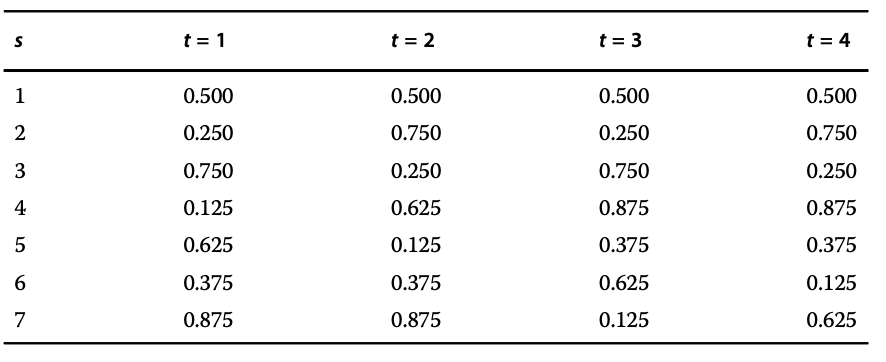

In [ ]:
lp_seq = lp_seq()

# Apply LPτ-sequences in Objective Function

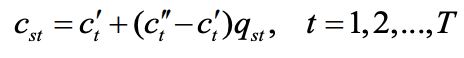

## Functions

In [ ]:
# get_cst
def get_cst(lp_seq, t, df_final, param):

    if param == "supply":
        df = df_final[["month", "Product", "min_value", "max_value"]]
    elif param == "eta":
        df = df_final[
                [
                       "Vessel IMO*",
                       "vessel_IMO-month-Port-vessel_class",
                        "min_value",
                        "max_value"
                  ]
        ]
    elif param == "berth":
        df = df_final
    elif param == "demand":
        df = df_final[["month", "Product", "min_value", "max_value"]]
    else:
        raise Exeption("Necessary inform a valid param.")

    for idx, q in enumerate(lp_seq["t=" + str(t)]):
        df["cst_" + str(idx + 1)] = 0
        df["cst_" + str(idx + 1)] = df["min_value"] + (
            (df["max_value"] - df["min_value"]) * q
        )
        if param == "supply":
            df.rename(columns={"Product": "Product*"}, inplace=True)
        elif param == "eta":
            df = df
        elif param == "berth":
            df.rename(columns={"Berth": "Berth*"}, inplace=True)
        elif param == "demand":
            df.rename(columns={"Product": "Product*"}, inplace=True)
        else:
            raise Exeption("Necessary inform a valid param.")
    return df


## Core

In [ ]:
## t=1 supply
t = 1
supply_cst = get_cst(lp_seq, t, final_supply, "supply")

## t=2 eta
t = 2
eta_cst = get_cst(lp_seq, t, final_eta, 'eta')

## t=3 berth
t = 3
berth_cst = get_cst(lp_seq, t, final_berth, 'berth')

## t=4 demand
t = 4
demand_cst = get_cst(lp_seq, t, final_demand, 'demand')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [ ]:
supply_cst

,month,Product*,min_value,max_value,cst_1,cst_2,cst_3,cst_4,cst_5,cst_6,cst_7
1,1,AF73,1.26,1.26,1.26,1.26,1.26,1.26,1.26,1.26,1.26
3,1,IOCJ,4.66,4.66,4.66,4.66,4.66,4.66,4.66,4.66,4.66
5,1,LOCJ,1.27,1.27,1.27,1.27,1.27,1.27,1.27,1.27,1.27
9,1,SFKT,2.59,2.59,2.59,2.59,2.59,2.59,2.59,2.59,2.59
11,2,AF70,7.04,7.04,7.04,7.04,7.04,7.04,7.04,7.04,7.04
...,...,...,...,...,...,...,...,...,...,...,...
145,12,LOCJ,0.66,1.28,0.97,0.82,1.13,0.74,1.05,0.89,1.20
146,12,MF14,0.00,0.13,0.06,0.03,0.10,0.02,0.08,0.05,0.11
149,12,SFKP,3.96,3.96,3.96,3.96,3.96,3.96,3.96,3.96,3.96
150,12,SFKT,2.00,4.01,3.00,2.50,3.51,2.25,3.25,2.75,3.76


# Fine-tune Objetive Functions

## Functions

In [ ]:
def get_input_supply(excel_list):
    inputs = []
    try:
        for df in enumerate(excel_list):
            df[1]['year'] = df[1]['Start Date*'].dt.year
            df[1]['month'] = df[1]['Start Date*'].dt.month
            inputs.append(df[1])
        return inputs
    except Exception as err:
        log("get_input_supply", "error in {f}: {err}", err)

def get_input_berth(excel_list):
    inputs = []
    try:
        for df in enumerate(excel_list):
             inputs.append(df[1])
        return inputs
    except Exception as err:
        log("get_input_berth", "error in {f}: {err}", err)

def get_input_demand(excel_list):
    inputs = []
    try:
        for df in enumerate(excel_list):
            df[1]['year'] = df[1]['Start Date*'].dt.year
            df[1]['month'] = df[1]['Start Date*'].dt.month
            inputs.append(df[1])
        return inputs
    except Exception as err:
        log("get_input_demand", "error in {f}: {err}", err)

def compare_values(old, new):
    try:
        if(old != float(0) and new == float(0)):
            return old
        return new
    except Exception as err:
        log("compare_values", "error in {f}: {err}", err)

def get_ajusted_inputs_supply(inputs, final_with_cst, variable):
    ed_inputs = []
    soan_cenarios = []
    for ed_input in inputs:
        df_aux = ed_input.merge(final_with_cst, how='outer')
        ed_inputs.append(df_aux)
    try:
        for ed_input in ed_inputs:
            final_inputs = []
            for idx, q in enumerate(lp_seq['t=1']):
                ed_input[str(variable) + '_' + str(idx+1)] = 0
                ed_input[str(variable) + '_' + str(idx+1)] = ed_input['Amount*'].multiply(
                    ed_input['cst_' + str(idx+1)], fill_value=0)

            for idx, q in enumerate(lp_seq['t=1']):
                orig_columns = inputs[0].columns.values.tolist()
                orig_columns.insert(-1, str(variable) + '_' + str(idx+1))
                df_aux = ed_input[orig_columns]
                df_aux[str(variable) + '_' + str(idx+1)] = df_aux.apply(lambda x: compare_values(
                    x['Amount*'], x[str(variable) + '_' + str(idx + 1)]), axis=1)
                df_aux.drop(['month', 'year', 'Amount*'], inplace=True, axis=1)
                df_aux.rename(columns={str(variable) + '_' +
                              str(idx+1): 'Amount*'}, inplace=True)
                df_aux = df_aux[df_aux['Port*'].notna()]

                final_inputs.append(df_aux)
            soan_cenarios.append(final_inputs)
        return soan_cenarios
    except Exception as err:
        log("get_ajusted_inputs_supply", "error in {f}: {err}", err)


def get_ajusted_inputs_eta(inputs, final_with_cst, variable):
    try:
        m = ''
        return m
    except Exception as err:
        log("get_ajusted_inputs_eta", "error in {f}: {err}", err)

def get_ajusted_inputs_berth(inputs, final_with_cst, variable):
    try:
        ed_inputs = []
        soan_cenarios = []
        for ed_input in inputs:
            ed_input['month'] = ed_input["Date*"].dt.month
            df_aux = ed_input.merge(final_with_cst, on =['month', 'Port*', 'Berth*'], how='inner')
            df_aux = df_aux.fillna(0)
            ed_inputs.append(df_aux)

        for ed_input in ed_inputs:
            final_inputs = []

            for idx, q in enumerate(lp_seq['t=3']):
                orig_columns = inputs[0].columns.values.tolist()
                orig_columns.insert(-1, 'cst_' + str(idx+1))
                df_aux = ed_input[orig_columns]
                df_aux['cst_' + str(idx+1)] = df_aux.apply(lambda x: compare_values(
                    x['Monthly Outflow Capacity*'], x['cst_'+str(idx + 1)]), axis=1)
                df_aux.drop(['Monthly Outflow Capacity*', 'month'],
                            inplace=True, axis=1)
                df_aux.rename(
                    columns={'cst_' + str(idx+1): 'Monthly Outflow Capacity*'}, inplace=True)
                final_inputs.append(df_aux)

            soan_cenarios.append(final_inputs)
        return soan_cenarios
    except Exception as err:
        log("get_ajusted_inputs_berth", "error in {f}: {err}", err)

def get_ajusted_inputs_demand(inputs, final_with_cst, variable):
    ed_inputs = []
    soan_cenarios = []
    for ed_input in inputs:
        df_aux = ed_input.merge(final_with_cst, how='outer')
        ed_inputs.append(df_aux)

    try:
        for ed_input in ed_inputs:
            final_inputs = []

            for idx, q in enumerate(lp_seq['t=4']):
                ed_input[str(variable) + '_' + str(idx+1)] = 0
                ed_input[str(variable) + '_' + str(idx+1)] = ed_input['Quantity*'].multiply(
                    ed_input['cst_' + str(idx+1)], fill_value=0)

            for idx, q in enumerate(lp_seq['t=4']):
                orig_columns = inputs[0].columns.values.tolist()
                orig_columns.insert(-1, str(variable) + '_' + str(idx+1))
                df_aux = ed_input[orig_columns]
                df_aux[str(variable) + '_' + str(idx+1)] = df_aux.apply(lambda x: compare_values(
                    x['Quantity*'], x[str(variable) + '_' + str(idx + 1)]), axis=1)
                df_aux.drop(['month', 'year', 'Quantity*'],
                            inplace=True, axis=1)
                df_aux.rename(
                    columns={str(variable) + '_' + str(idx+1): 'Quantity*'}, inplace=True)
                df_aux = df_aux[df_aux['Port Origin*'].notna()]
                final_inputs.append(df_aux)

            soan_cenarios.append(final_inputs)

        return soan_cenarios

    except Exception as err:
        log("get_ajusted_inputs_demand", "error in {f}: {err}", err)


# get_ajusted_inputs


def get_ajusted_inputs(inputs, final_with_cst, variable):
    if variable == "supply":
      return get_ajusted_inputs_supply(inputs, final_with_cst, variable)
    elif variable == "eta":
      return get_ajusted_inputs_eta(inputs, final_with_cst, variable)
    elif variable == "berth":
      return get_ajusted_inputs_berth(inputs, final_with_cst, variable)
    elif variable == "demand":
      return get_ajusted_inputs_demand(inputs, final_with_cst, variable)
    else:
      Exception("Necessary inform a valid variable string")

# core_supply()


def core_supply(cst, path):
    try:
        sheets = get_data(year, month, 'Supply', path)
        raw_data = get_input_supply(sheets)
        inputs = get_ajusted_inputs(raw_data, cst, 'supply')
        return inputs
    except Exception as err:
        log("core_supply", "error in {f}: {err}", err)

# core_eta()


def core_eta(cst, path):
    try:
        sheets = get_data(year, month, 'ETA', path)
        raw_data = get_input_supply(sheets)
        inputs = get_ajusted_inputs(raw_data, cst, 'eta')
        return inputs
    except Exception as err:
        log("core_eta", "error in {f}: {err}", err)

# core_berth()


def core_berth(cst, path):
    try:
        sheets = get_data(year, month, 'Berth Outflow Capacity', path)

        raw_data = get_input_berth(sheets)
        inputs = get_ajusted_inputs(raw_data, cst, 'berth')
        return inputs
    except Exception as err:
        log("core_berth", "error in {f}: {err}", err)

# core_demand()


def core_demand(cst, path):
    try:
        sheets = get_data(year , month, 'Demand', path)
        raw_data = get_input_demand(sheets)
        inputs = get_ajusted_inputs(raw_data, cst, 'demand')
        return inputs
    except Exception as err:
        log("core_demand", "error in {f}: {err}", err)


## Core

In [ ]:
path = get_soan_path()
# Supply
inputs_supply = core_supply(supply_cst, path)

# ETA
inputs_eta = core_eta(eta_cst, path)

# Berth
inputs_berth = core_berth(berth_cst, path)

# Demand
inputs_demand = core_demand(demand_cst, path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/pyth

In [ ]:
df_supply = inputs_supply[0][0]
df_supply["year"] = df_supply["Start Date*"].dt.year
df_supply["month"] = df_supply["Start Date*"].dt.month
df_supply['year-month'] = df_supply['Start Date*'].apply(lambda x: str(x.year) + '-' + str(x.month))
df_supply['port-product-year-month'] = df_supply['Port*'].astype(str) + '-' + df_supply['Product*'].astype(str) + '-' + df_supply['year-month'].astype(str)


In [ ]:
df_demand = inputs_demand[0][0]
df_demand["year"] = df_demand["Start Date*"].dt.year
df_demand["month"] = df_demand["Start Date*"].dt.month
df_demand['year-month'] = df_demand['Start Date*'].apply(lambda x: str(x.year) + '-' + str(x.month))
df_demand['port-product-year-month'] = df_demand['Port Origin*'].astype(str) + '-' + df_demand['Product*'].astype(str) + '-' + df_demand['year-month'].astype(str)
df_demand

,!Supply Group,Port Origin*,Country Origin*,Product*,Client*,Country Dest.*,Incoterm*,Purpose,Allocation Type,Start Date*,...,Qtt. Allowance (%),!Source,Contingency,Demand No.,Priority,Quantity*,year,month,year-month,port-product-year-month
0,NaN,TRM,Malaysia,BBM4,FHS,Vietnam,CFR,SALE,LTC,2019-09-01 12:00:00,...,10.00,GPVP,NaN,117684,False,"171,105.00",2019,9,2019-9,TRM-BBM4-2019-9
1,NaN,TRM,Malaysia,BBM4,ITC,China,CFR,SALE,SPOT,2020-09-01 12:00:00,...,10.00,SUPPLY,NaN,124221,False,"2,280,000.00",2020,9,2020-9,TRM-BBM4-2020-9
2,NaN,TRM,Malaysia,BBM4,HOD,Vietnam,CFR,SALE,LTC,2019-09-01 12:00:00,...,10.00,GPVP,NaN,117813,False,"54,991.00",2019,9,2019-9,TRM-BBM4-2019-9
3,NaN,TRM,Malaysia,BBM4,HPS,Vietnam,CFR,SALE,LTC,2019-09-01 12:00:00,...,10.00,GPVP,NaN,117262,False,"102,878.00",2019,9,2019-9,TRM-BBM4-2019-9
4,NaN,TRM,Malaysia,BBM4,ITC,China,CFR,SALE,SPOT,2020-09-01 12:00:00,...,100.00,AUXILIARY,NaN,#125157,False,"97,902.00",2020,9,2020-9,TRM-BBM4-2020-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,NaN,PMA,Brazil,MF14,ITC,China,CFR,SALE,SPOT,2020-06-01 12:00:00,...,10.00,SUPPLY,NaN,124719,False,"169,000.00",2020,6,2020-6,PMA-MF14-2020-6
1126,NaN,DEF,China,GF88,ITC,China,CFR,SALE,SPOT,2020-08-01 12:00:00,...,10.00,SUPPLY,NaN,124229,False,"480,000.00",2020,8,2020-8,DEF-GF88-2020-8
1127,NaN,DEF,China,GF88,ITC,China,CFR,SALE,SPOT,2020-07-01 12:00:00,...,10.00,SUPPLY,NaN,124239,False,"240,000.00",2020,7,2020-7,DEF-GF88-2020-7
1128,NaN,TTE,Brazil,AF25,ITC,China,CFR,SALE,SPOT,2020-05-01 12:00:00,...,10.00,GPVP,NaN,123705,False,"231,406.00",2020,5,2020-5,TTE-AF25-2020-5


In [ ]:
def max_value(incoterm,amount, quantity):
  if incoterm != 'FOB':
    return quantity
  elif quantity >= amount:
    return quantity
  else:
    return amount

def is_nan(old_value, new_value):
    try:
        if math.isnan(old_value):
            return new_value
        return old_value
    except Exception as err:
        log("is_nan", "error in {f}: {err}", err)

df = df_demand.merge(df_supply, how = 'outer')

df['max_values'] =   df.apply(lambda x: max_value(x['Incoterm*'], x['Amount*'], x['Quantity*']), axis=1)
df_x = df
orig_columns = inputs_demand[0][0].columns.values.tolist()
orig_columns.insert(-1, 'max_values')
orig_columns.remove('Product*')
orig_columns.remove('port-product-year-month')
orig_columns.remove('month')
orig_columns.remove('year')
orig_columns.remove('year-month')
df_aux = df[orig_columns]
df_aux.drop_duplicates(keep=False,inplace=True)
df_aux['max_values'] =   df.apply(lambda x: is_nan(x['max_values'], x['Quantity*']), axis=1)
df_aux.drop_duplicates(keep=False,inplace=True)

df_aux

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,!Supply Group,Port Origin*,Country Origin*,Client*,Country Dest.*,Incoterm*,Purpose,Allocation Type,Start Date*,End Date*,...,Max Lot (t),Min Deadline,Max Deadline,Qtt. Allowance (%),!Source,Contingency,Demand No.,Priority,Quantity*,max_values
0,NaN,TRM,Malaysia,FHS,Vietnam,CFR,SALE,LTC,2019-09-01 12:00:00,2019-09-30 12:00:00,...,NaN,NaN,NaN,10.00,GPVP,NaN,117684,False,"171,105.00","171,105.00"
1,NaN,TRM,Malaysia,HOD,Vietnam,CFR,SALE,LTC,2019-09-01 12:00:00,2019-09-30 12:00:00,...,NaN,NaN,NaN,10.00,GPVP,NaN,117813,False,"54,991.00","54,991.00"
2,NaN,TRM,Malaysia,HPS,Vietnam,CFR,SALE,LTC,2019-09-01 12:00:00,2019-09-30 12:00:00,...,NaN,NaN,NaN,10.00,GPVP,NaN,117262,False,"102,878.00","102,878.00"
3,NaN,TRM,Malaysia,ITC,China,CFR,SALE,SPOT,2020-09-01 12:00:00,2020-09-30 12:00:00,...,NaN,NaN,NaN,10.00,SUPPLY,NaN,124221,False,"2,280,000.00","2,280,000.00"
4,NaN,TRM,Malaysia,ITC,China,CFR,SALE,SPOT,2020-09-01 12:00:00,2020-09-29 12:00:00,...,NaN,NaN,NaN,100.00,AUXILIARY,NaN,#125157,False,"97,902.00","97,902.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,NaN,PMA,Brazil,ITC,China,CFR,SALE,SPOT,2020-06-01 12:00:00,2020-06-30 12:00:00,...,NaN,NaN,NaN,10.00,SUPPLY,NaN,124719,False,"169,000.00","169,000.00"
1126,NaN,DEF,China,ITC,China,CFR,SALE,SPOT,2020-08-01 12:00:00,2020-08-31 12:00:00,...,NaN,NaN,NaN,10.00,SUPPLY,NaN,124229,False,"480,000.00","480,000.00"
1127,NaN,DEF,China,ITC,China,CFR,SALE,SPOT,2020-07-01 12:00:00,2020-07-31 12:00:00,...,NaN,NaN,NaN,10.00,SUPPLY,NaN,124239,False,"240,000.00","240,000.00"
1128,NaN,TTE,Brazil,ITC,China,CFR,SALE,SPOT,2020-05-01 12:00:00,2020-05-31 12:00:00,...,NaN,NaN,NaN,10.00,GPVP,NaN,123705,False,"231,406.00","231,406.00"


# Export Objective Function

## Functions

In [ ]:
# remove_exist_file


def remove(path):
    try:
        os.remove(path)
    except OSError:
        pass

# get_soan_scenarios


def get_soan_scenarios(path, month, year):

    path = "{path}/*{month}*{year}/".format(
        path=str(path), month=str(month), year=str(year)
    )
    file_list = glob.glob(path)
    return file_list

# folder_names


def folder_names(folder_list):
    names = []
    for folder in folder_list:
        name = folder.split('/')[-2]
        names.append(name)
    return names

# create_folders


def create_folders(names, number_scenarios):
    path = Path('gdrive', 'MyDrive', 'input')

    for name in names:
        folder_path = str(str(path) + '/' + name)

        if os.path.exists(folder_path) == False:
            os.mkdir(folder_path)

        for n in range(0, number_scenarios):
            scenario_path = str(folder_path + '/scenario_' + str(n+1))
            if os.path.exists(scenario_path) == False:
                os.mkdir(scenario_path)


# create_files
def create_files(names, number_scenarios, inputs, file_name):
    path = Path('gdrive', 'MyDrive', 'input')
    for idx, name in enumerate(names):
        folder_path = str(str(path) + '/' + name)
        dfs = inputs[idx]
        for n in range(0, number_scenarios):
            df = dfs[n]
            scenario_path = str(folder_path + '/scenario_' + str(n+1))
            file_path = Path(str(scenario_path + '/' + file_name + '.xlsx'))
            remove(file_path)
            df.to_excel(excel_writer=file_path, index=False)
# prepare_export
def prepare_export():
    path = get_soan_path()
    folder_list = get_soan_scenarios(path, month, year)
    names = folder_names(folder_list)
    folders = create_folders(names, 7)
    return names


## Core

In [ ]:
names = prepare_export()

create_files(names, 7,inputs_supply, 'Supply')
create_files(names, 7,inputs_supply, 'ETA')
create_files(names, 7,inputs_berth, 'Berth Outflow Capacity')
create_files(names, 7,inputs_demand, 'Demand')

## Max Quantity

- Pegar o cost analysis report em cada pasta, somar a coluna de quantidade, e colocar na diagonal da matriz.


- Pegar os valores das outras colunas da Matriz.
  -

In [ ]:

def get_path():
    try:
        path = Path("gdrive", "MyDrive")
        return path
    except FileNotFoundError as err:
        raise err
    except Exception as err:
        raise log("get_path", "error in {f}: {err}", err)


# get_soan_path
def get_otm_cenarios():
    path = get_path()
    try:
        path_aux = "{path}/input/Analisys/scenario_*/Cenario*.xlsx".format(
            path=str(path)
        )
        file_list = glob.glob(path_aux)
        #print(file_list)
        mydic = {}
        for idx,file in enumerate(file_list):
          path_2 = "{path}/input/Analisys/scenario_{idx}/Cenario*.xlsx".format(
              path=str(path), idx=str(idx+1)
          )
          file_list_2 = glob.glob(path_2)
        #  print(path_2)
          df = pd.read_excel(file_list_2[0])
          mydic["y"+ str(idx+1)] = df["Qtt (t)"].sum()

        return mydic
    except Exception as err:
          log("get_otm_cenarios", "error in {f}: {err}", err)




otm_values = get_otm_cenarios();

# Matriz pay-off and robust scenarios

In [ ]:
# Used external tool for generate the Matriz pay-off (Software TDMCI License  BR512021003034-6)